In [113]:
import pickle
import os
import re
import json
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from tqdm.notebook import tqdm

from functools import reduce
import utils as ut

In [114]:
# Enable automatic reloading of modules before executing code
%load_ext autoreload
%autoreload 2


import plotting as pl
from models import model as md
import utils as ut

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
def extract_results_id_embeddings(lmbda, learning_rate, rnd_seed, modelversion, modelname):
    all_dirs = []
    l_all_results = []
    l_all_models = []
    
    for la in lmbda:
        for lr in learning_rate:
            results_dir_ID = os.path.join(
                "./results", modelversion, modelname,
                f"lambda{str(la)}", f"lr{str(lr)}", f'seed{rnd_seed}'
                )
            all_dirs.append(results_dir_ID)
    for i, d in enumerate(all_dirs):
        file_path = os.path.join(d, 'results.json')
        if os.path.isfile(file_path):
            with open(file_path, "r") as f:
                l_results = json.load(f)
                l_all_results.append(l_results)
        else:
            print(file_path + ": not found")
        p = os.path.join(d, "model", "model_epoch0250.tar")
        if os.path.isfile(p):
            m = torch.load(p, weights_only=False, map_location=torch.device("cpu"))
            l_all_models.append(m)
    return l_all_models

In [140]:
def extract_results_id_embeddings(lmbda, learning_rate, rnd_seed, modelversion, modelname):
    all_dirs = []
    l_all_results = []
    l_all_models = []
    
    for la in lmbda:
        for lr in learning_rate:
            results_dir_ID = os.path.join(
                "./results", modelversion, modelname,
                f"lambda{str(la)}", f"lr{str(lr)}", f'seed{rnd_seed}'
                )
            all_dirs.append(results_dir_ID)
    for i, d in enumerate(all_dirs):
        file_path = os.path.join(d, 'results.json')
        if os.path.isfile(file_path):
            with open(file_path, "r") as f:
                l_results = json.load(f)
                l_all_results.append(l_results)
        else:
            print(file_path + ": not found")
        p = os.path.join(d, "model", "model_epoch0250.tar")
        if os.path.isfile(p):
            m = torch.load(p, weights_only=False, map_location=torch.device("cpu"))
            l_all_models.append(m)
    return l_all_models

In [141]:
# id model
lmbda = [0.00005, 0.0005, 0.01]#[0.0, 0.000025]#
learning_rate = [0.01, 0.0005]#[0.1, 0.05]#
rnd_seed = '852'
modelversion = "ID-on-embeddings"
modelname = "Word2Vec"
# modelname = os.path.join("answerdotai", "ModernBERT-based")
l_all_models_id = extract_results_id_embeddings(lmbda, learning_rate, rnd_seed, modelversion, modelname)

In [142]:
l_all_models_id[0]

{'epoch': 250,
 'model_state_dict': OrderedDict([('individual_slopes.weight',
               tensor([[ 1.3940e+00, -2.7533e-04,  9.6662e-01,  ..., -2.2626e-05,
                         5.5164e-05,  1.4560e-05],
                       [-2.9542e-04,  5.4848e-04, -1.0273e-03,  ...,  2.7835e-03,
                        -4.2193e-04, -1.1019e-03],
                       [-4.6640e-04, -3.6846e-05, -1.2259e+00,  ...,  4.7362e-05,
                         9.4038e-01,  3.1156e-05],
                       ...,
                       [-1.4438e+00,  8.5116e-01, -6.0763e-02,  ...,  6.9682e-05,
                         3.8630e-06, -2.7409e-01],
                       [-1.2151e+00,  1.1570e+00, -1.0200e+00,  ..., -1.8730e-01,
                         2.5905e-02, -3.4303e-02],
                       [ 3.7419e-02,  1.1614e-02,  1.0281e-01,  ...,  8.0216e-03,
                         4.6273e-02,  2.2904e-02]]))]),
 'optim_state_dict': {'state': {0: {'step': tensor(1273000.),
    'exp_avg': tensor([[ 1.89

In [143]:
l_df_train_eval_id = [
    pd.DataFrame({
        "lambda": l["lambda"],
        "lr": l["lr"],
        "train_acc": l["train_accs"],
        "val_acc": l["val_accs"],
    })
    for l in l_all_models_id
]

In [144]:
df_train_eval_id = reduce(lambda x, y: pd.concat([x, y], axis=0, ignore_index=True), l_df_train_eval_id)

In [145]:
df_train_eval_id["epoch"] = df_train_eval_id.groupby(["lambda", "lr"]).cumcount()

In [146]:
df_train_eval_long_id = pd.melt(
    df_train_eval_id, 
    id_vars=["lambda", "lr", "epoch"], 
    value_vars = ["train_acc", "val_acc"], 
    var_name = "Variable",
    value_name = "Accuracy"
)

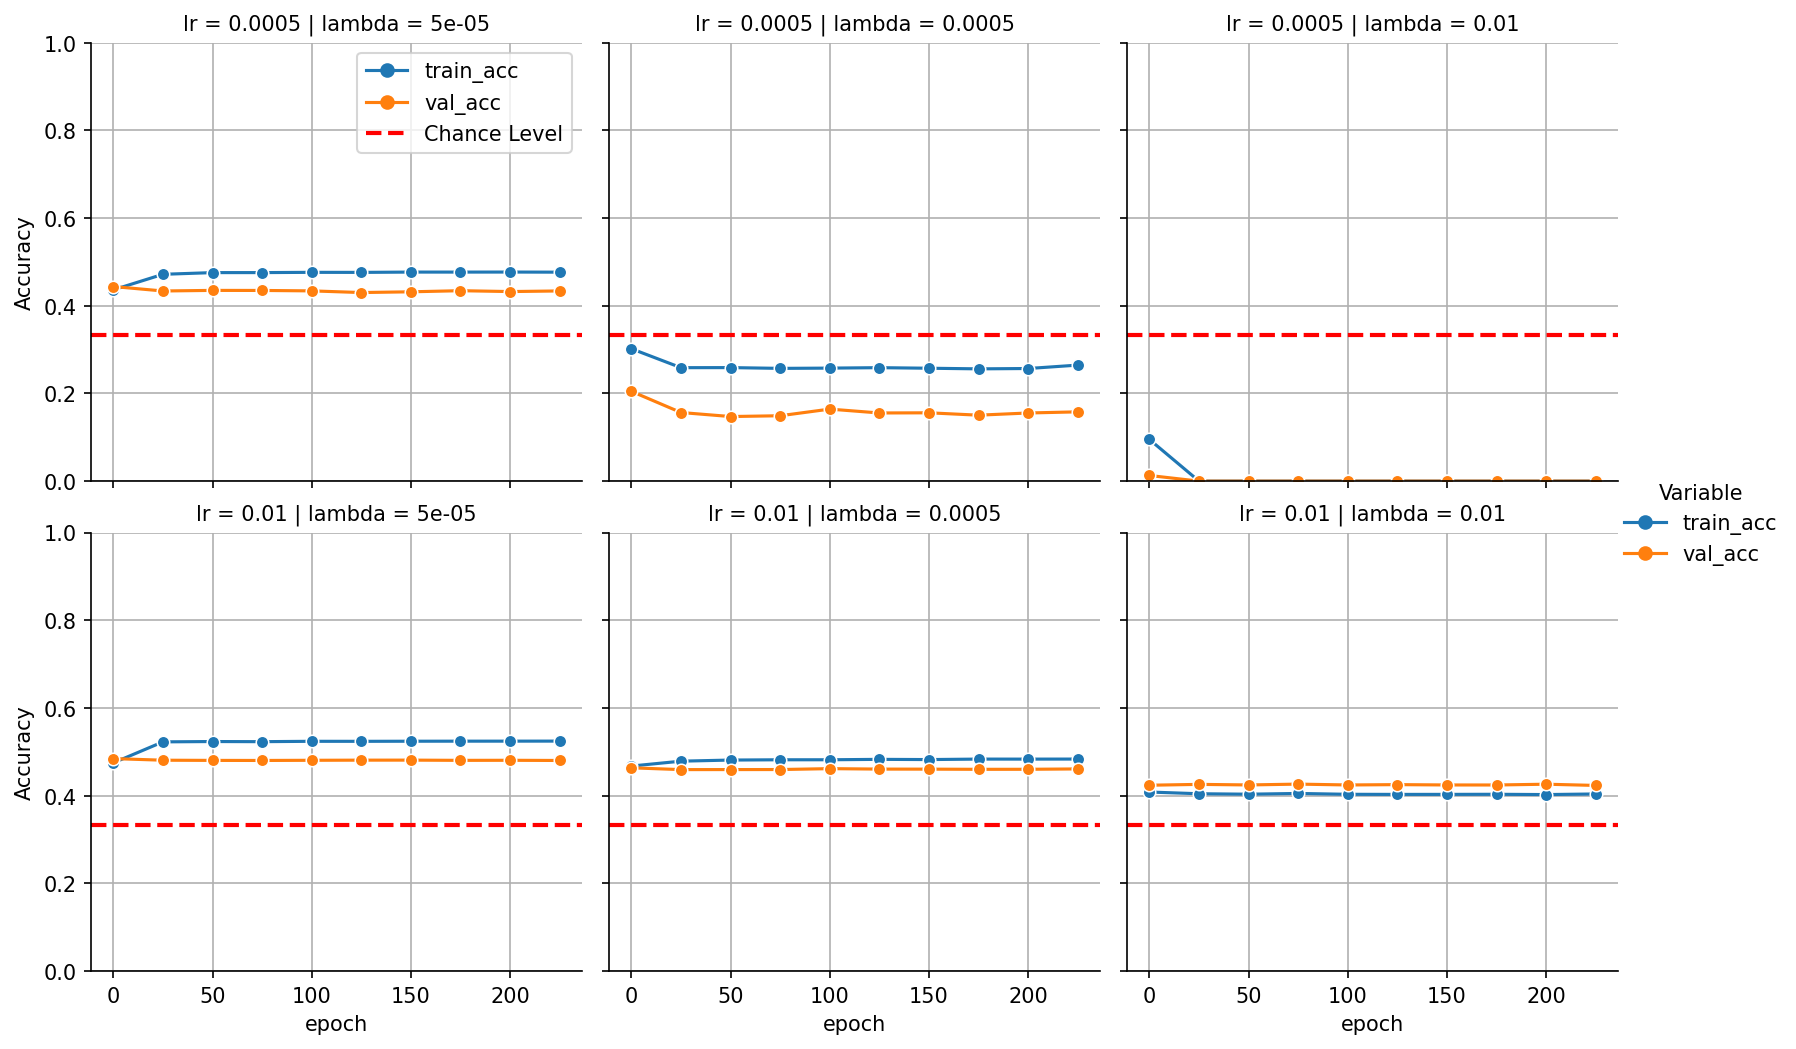

In [147]:
# Create the FacetGrid without specifying an external axis
g = sns.relplot(
    data=df_train_eval_long_id.query("epoch % 25 == 0"), x='epoch', y='Accuracy', 
    col='lambda', row="lr", height=4, hue="Variable",
    marker="o", aspect=1, kind="line")
# Add gridlines to each facet 
for i, ax in enumerate(g.axes.flat): 
    ax.grid(True)
    ax.axhline(y=.33333, color='red', linestyle='--', linewidth=2, label='Chance Level')
    
    #ax.set_xlim(0, 400)
    ax.set_ylim(0, 1)
    if i == 0:
        ax.legend()

# Adjust the plot size
g.fig.set_size_inches(12, 7)
g.fig.set_dpi(150)

plt.show()

In [11]:
df_train_eval_long_id.query('Variable == "val_acc"').sort_values("Accuracy", ascending = False).head()

,lambda,lr,epoch,Variable,Accuracy
1500,0.00005,0.01,0,val_acc,0.484548
1502,0.00005,0.01,2,val_acc,0.482647
1704,0.00005,0.01,204,val_acc,0.482074
1501,0.00005,0.01,1,val_acc,0.481940
1531,0.00005,0.01,31,val_acc,0.481885


In [12]:
df_train_eval_long_id.query('epoch == 249 & Variable == "val_acc"').sort_values("Accuracy", ascending = False).head()

,lambda,lr,epoch,Variable,Accuracy
1749,0.00005,0.0100,249,val_acc,0.481053
2249,0.00050,0.0100,249,val_acc,0.460699
1999,0.00005,0.0005,249,val_acc,0.430589
2749,0.01000,0.0100,249,val_acc,0.421634
2499,0.00050,0.0005,249,val_acc,0.149277


# Compare to average embedding performance

In [13]:
model_id = "Word2Vec"
triplets_dir = './data/'
device = "cpu"
l_embeddings = ut.load_avg_embeddings(model_id=model_id, device=device)
# load triplets into memory
train_triplets, test_triplets = ut.load_data_ID(
    device=device, triplets_dir=triplets_dir, testcase=False)


...Could not find any .npy files for current modality.
...Now searching for .txt files.



In [15]:
anchors = torch.Tensor(np.array([l_embeddings[i] for i in list(test_triplets[:, 0])]))
positives = torch.Tensor(np.array([l_embeddings[i] for i in list(test_triplets[:, 1])]))
negatives = torch.Tensor(np.array([l_embeddings[i] for i in list(test_triplets[:, 2])]))

In [35]:
sims = ut.compute_similarities(anchors, positives, negatives, method="odd_one_out")

In [40]:
acc_avg = np.sum((sims[0] > sims[1]).numpy() & (sims[0] > sims[2]).numpy()) / test_triplets.shape[0]

plot the average accuracy together with the by-participant weighted accuracy

In [16]:
array_weights_id = l_all_models_id[0]["model_state_dict"]["individual_slopes.weight"]

In [17]:
ids = test_triplets[:, 3].numpy()

In [18]:
anchors_weighted = [a*array_weights_id.numpy()[ids[id], :] for id, a in enumerate(anchors)]
positives_weighted = [a*array_weights_id.numpy()[ids[id], :] for id, a in enumerate(positives)]
negatives_weighted = [a*array_weights_id.numpy()[ids[id], :] for id, a in enumerate(negatives)]

In [19]:
from functools import partial

In [20]:
f_partial = partial(ut.delta_avg_id, anchors, positives, negatives, anchors_weighted, positives_weighted, negatives_weighted, ids)

In [21]:
ids_unique_sorted = np.sort(np.unique(ids))

In [32]:
l_deltas = list(tqdm(map(f_partial, ids_unique_sorted), total=len(ids_unique_sorted), desc="Processing"))

Processing:   0%|          | 0/264 [00:00<?, ?it/s]

In [23]:
df_ns = pd.DataFrame(ids, columns=['id'])
df_ns = df_ns.groupby("id")["id"].count() * 4
df_ns = df_ns.reset_index(name = "n_train")
df_ns["delta"] = l_deltas

In [24]:
df_ns.head()

,id,n_train,delta
0,0,2320,0.025862
1,1,432,-0.006897
2,2,1008,-0.029310
3,3,2192,0.029310
4,4,3424,0.018966


In [25]:
df_ns.to_csv("data/deltas-word2vec-weighted.csv")

In [44]:
df_train_eval_long_id.head()

,lambda,lr,epoch,Variable,Accuracy
0,0.00005,0.01,0,train_acc,0.474892
1,0.00005,0.01,1,train_acc,0.505613
2,0.00005,0.01,2,train_acc,0.515579
3,0.00005,0.01,3,train_acc,0.517361
4,0.00005,0.01,4,train_acc,0.519886


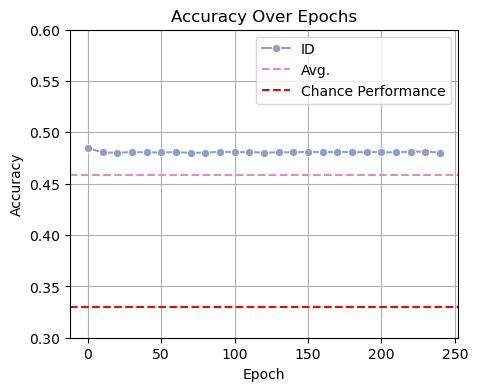

In [161]:
palette = sns.color_palette("Set2")[2:]

plt.figure(figsize=(5, 4))  # Set the size of the plot
sns.lineplot(
    x="epoch", y="Accuracy", 
    data=df_train_eval_long_id.query(
        "lr == 0.01 & Variable == 'val_acc' & `lambda` == 0.00005 & epoch % 10 == 0"
    ), color=palette[0], label = "ID",
    markers=True, marker="o")
# Add a horizontal line at 0.34
plt.axhline(y=acc_avg, color=palette[1], linestyle='--', label='Avg.')
plt.axhline(y=.33, color='red', linestyle='--', label='Chance Performance')

# Optionally, you can customize other properties

# Set the x-axis range
plt.ylim(0.3, 0.6)


# Optionally, you can customize other properties
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
sns.lineplot(

In [66]:
from os.path import join as pjoin


In [70]:

results_dir = f"""semantic-representations-ID/results/in-context-learning/lama-3.1-{70}B"""
if not os.path.exists(results_dir):
    os.makedirs(results_dir)


train_triplets = torch.from_numpy(np.loadtxt(
    pjoin("data/", 'train_90_ID.txt'))).to(device).type(torch.LongTensor)
triplet_ids = train_triplets.detach().numpy()
tbl_labels = pd.read_csv(
    "data/unique_id.txt", delimiter="\\", header=None)
tbl_labels[0] = tbl_labels[0].str.replace(r'\d+', '', regex=True)

In [72]:

def randomize_and_extract_trial(tbl_labels, l_ids):
    tbl_select = tbl_labels.iloc[l_ids[0:3]]
    tbl_select.reset_index(drop=True, inplace=True)
    rand_order = np.random.choice([0, 1, 2], 3, replace=False)
    tbl_reordered = tbl_select.iloc[rand_order].reset_index(drop=True)
    tbl_reordered["rnd"] = rand_order
    tbl_return = pd.DataFrame({
        "1": [tbl_reordered.iloc[0, 0]],
        "2": [tbl_reordered.iloc[1, 0]],
        "3": [tbl_reordered.iloc[2, 0]],
        "selected": np.where(tbl_reordered["rnd"] == 2)[0] + 1
    })
    return tbl_return

In [74]:
randomize_and_extract_partial = partial(
    randomize_and_extract_trial, tbl_labels)

In [78]:
participant_id = 0
n_trials = 10

In [79]:
l_trials = list(map(randomize_and_extract_partial,
                triplet_ids[triplet_ids[:, 3] == participant_id]))

df_trials = pd.concat(l_trials)

l_all_current_tasks = []
l_all_previous_trials = []
for current_trial_id in range(0, n_trials):
    l_previous_trials = []
    current_trial = df_trials.iloc[current_trial_id, :]
    current_task = ", ".join(
        [f"{index+1}. {item}" for index, item in enumerate(current_trial[0:3])])
    if current_trial_id > 0:
        for previous_trial_id in range(0, (current_trial_id)):
            previous_trial = df_trials.iloc[previous_trial_id, :]
            response_prev = f"""{previous_trial["selected"]}. {previous_trial.iloc[previous_trial["selected"]-1]} in: """ + ", ".join(
                [f"{index+1}. {item}" for index, item in enumerate(previous_trial[0:3])])
            l_previous_trials.append(response_prev)
    l_all_current_tasks.append(current_task)
    l_all_previous_trials.append(l_previous_trials)

In [103]:
system_input = (
        "You are a cognitive scientist and you are given a by-trial data set from a participant " +
        "in the odd-one-out task. For each trial, you are presented with the three words and " +
        "the participant's response,\ni.e.,the word the participant thinks is the odd one out of the three. " +

        "\nYour goal is to predict, for a new triplet of words, " +
        "which word the person is most likely\nto identify as the odd one out. " +
        "Note that in the very first trial,\nyou are only presented with the three words, but no previous responses."

    )
input_text = (
        "In an odd-one-out task, a participant is presented with three objects in each trial.\n" +
        "The participant is instructed to select the object they think\nis most dissimilar from the other presented objects.\n" +
        "A participant's response is neither correct nor incorrect.\nThe response should simply reflect the participant's " +
        "perceived semantic similarity between the three objects."
    )

In [104]:
trial_id = 5
l_prev_concat = l_all_previous_trials[trial_id]
current = l_all_current_tasks[trial_id]

In [109]:
question_text = (
                f"""\nThe current trial is trial nr. {5 + 1}"""
                "\nWhen reasoning what logic the person used, think in steps - for example:\n"
                "is a participant sensitive to a set of dimensions in semantic space (e.g., technology, food, animals, ...)?"
                "\nHow would this person respond given three new objects?\n"
                "\nHere are the previous responses from the participant:\n" +
                "\n".join(l_prev_concat) +
                "\n\nPlease first respond with the respective number (i.e., 1., 2., or 3.), and only then explain your reasoning.\n"
                "Make sure that the number corresponds with your reasoning. For example, if you respond with 2. in the triplet\n"
                "1. house, 2. zebra, 3. garden, then the number 2. should only refer to 2. zebra\n"
                "\nWhich of the following three words is the person to denote as the odd-one-out?\n"
                f"""{current}?"""
            )

In [110]:
user_input = input_text + question_text

In [111]:
print(system_input)

You are a cognitive scientist and you are given a by-trial data set from a participant in the odd-one-out task. For each trial, you are presented with the three words and the participant's response,
i.e.,the word the participant thinks is the odd one out of the three. 
Your goal is to predict, for a new triplet of words, which word the person is most likely
to identify as the odd one out. Note that in the very first trial,
you are only presented with the three words, but no previous responses.


In [112]:
print(user_input)

In an odd-one-out task, a participant is presented with three objects in each trial.
The participant is instructed to select the object they think
is most dissimilar from the other presented objects.
A participant's response is neither correct nor incorrect.
The response should simply reflect the participant's perceived semantic similarity between the three objects.
The current trial is trial nr. 6
When reasoning what logic the person used, think in steps - for example:
is a participant sensitive to a set of dimensions in semantic space (e.g., technology, food, animals, ...)?
How would this person respond given three new objects?

Here are the previous responses from the participant:
1. dagger in: 1. dagger, 2. macaroni, 3. cup
3. bullet in: 1. sheep, 2. badger, 3. bullet
2. detonator in: 1. icicle, 2. detonator, 3. aquarium
1. petri_dish in: 1. petri_dish, 2. bat, 3. wheat
1. moose in: 1. moose, 2. lava, 3. cereal

Please first respond with the respective number (i.e., 1., 2., or 3.),